<H1>Bike Sharing – Building an Interactive Web Application for Bike Rental Demand using Coefficients on Google Cloud</H1>

In [ ]:

# prior hours
bikes_hour_df_shift = bikes_hour_df[['dteday','hr','cnt']].groupby(['dteday','hr']).sum().reset_index()
bikes_hour_df_shift.sort_values(['dteday','hr'])
# shift the count of the last two hours forward so the new count can take in consideratio how the last two hours went 
bikes_hour_df_shift['sum_hr_shift_1'] = bikes_hour_df_shift.cnt.shift(+1)
bikes_hour_df_shift['sum_hr_shift_2'] = bikes_hour_df_shift.cnt.shift(+2)

bike_df_model_ready =  pd.merge(bikes_hour_df, bikes_hour_df_shift[['dteday', 'hr', 'sum_hr_shift_1', 'sum_hr_shift_2']], how='inner', on = ['dteday', 'hr'])

# drop NAs caused by our shifting fields around
bike_df_model_ready = bike_df_model_ready.dropna()

outcome = 'cnt'
# create a feature list for each modeling - experiment by adding features to the exclusion list
features = [feat for feat in list(bike_df_model_ready) if feat not in [outcome, 'instant', 'dteday','casual', 'registered']]  

# split data into train and test portions and model
X_train, X_test, y_train, y_test = train_test_split(bike_df_model_ready[features], 
                                                 bike_df_model_ready[['cnt']], 
                                                 test_size=0.3, random_state=42)
from sklearn import linear_model
model_lr = linear_model.LinearRegression()
 
# train the model on training set
model_lr.fit(X_train, y_train)

# make predictions using the testing set
predictions = model_lr.predict(X_test)

# root mean squared error
print("Root Mean squared error: %.2f" % sqrt(mean_squared_error(y_test, predictions))) 
 

**From UCI's Bike Sharing Dataset Data Set**
(from https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

<B>Abstract:</B> This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

<H2>Attribute Information from UCI:</H2>
(from https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)<BR><BR>
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv<BR> 

- **instant**: record index
- **dteday** : date
- **season** : season (1:springer, 2:summer, 3:fall, 4:winter)
- **yr** : year (0: 2011, 1:2012)
- **mnth** : month ( 1 to 12)
- **hr** : hour (0 to 23)
- **holiday** : weather day is holiday or not (extracted from [Web Link])
- **weekday** : day of the week
- **workingday** : if day is neither weekend nor holiday is 1, otherwise is 0.
+ **weathersit** : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp** : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- **atemp**: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- **hum**: Normalized humidity. The values are divided to 100 (max)
- **windspeed**: Normalized wind speed. The values are divided to 67 (max)
- **casual**: count of casual users
- **registered**: count of registered users
- **cnt**: count of total rental bikes including both casual and registered

**Download and unzip data set from UCI** 

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
 
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('/tmp/Bike-Sharing-Dataset')
 

In [101]:
bikes_hour_df_raw = pd.read_csv('/tmp/Bike-Sharing-Dataset/hour.csv')
bikes_day_df_raw = pd.read_csv('/tmp/Bike-Sharing-Dataset/day.csv')

In [102]:
bikes_hour_df_raw['temp'].describe()

count    17379.000000
mean         0.496987
std          0.192556
min          0.020000
25%          0.340000
50%          0.500000
75%          0.660000
max          1.000000
Name: temp, dtype: float64

In [103]:
bikes_hour_df_raw.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [104]:
bikes_day_df_raw.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


**This chapter will focus only on hourly data**

In [107]:
# remove useless features - date and signed users won't help the model for future predictions
bikes_hour_df = bikes_hour_df_raw.drop(['casual', 'registered'], axis=1) 


<H2>Data Exploration</H2>

In [108]:
bikes_hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
cnt           17379 non-null int64
dtypes: float64(4), int64(10), object(1)
memory usage: 2.0+ MB


In [109]:
print(bikes_hour_df.describe())

          instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.

**Let's look at the outcome variable we're going to use to train the model - Rental Counts**

In [110]:
bikes_hour_df['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

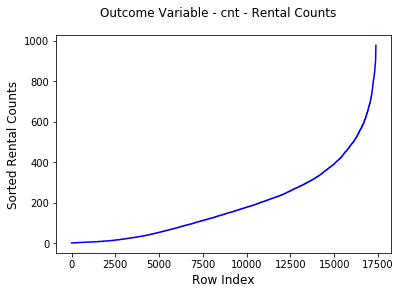

In [111]:
fig,ax = plt.subplots(1)
ax.plot(sorted(bikes_hour_df['cnt']), color='blue')
ax.set_xlabel("Row Index", fontsize=12)
ax.set_ylabel("Sorted Rental Counts", fontsize=12)
fig.suptitle('Outcome Variable - cnt - Rental Counts')
plt.show()


**Let's look at the Quantitative Features versus Rental Counts**

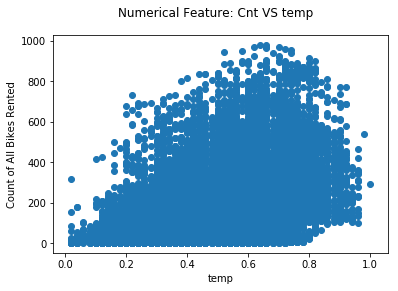

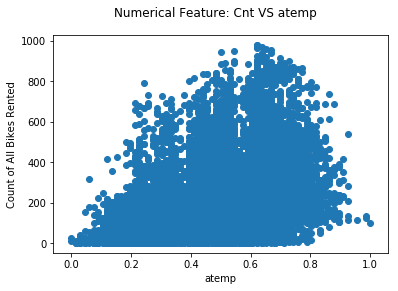

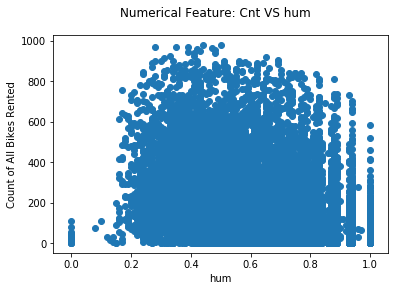

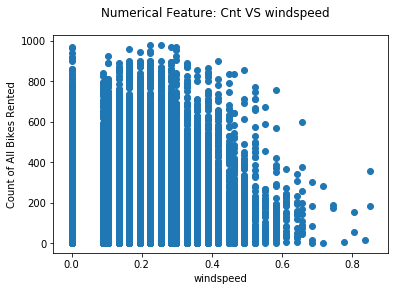

In [112]:
# build a loop and look for floats - quick way of learning about the dataset 
counter_ = 0
for tp in bikes_hour_df.dtypes:
    if (tp == "float64"):
        bikes_hour_df = bikes_hour_df.sort_values(bikes_hour_df.dtypes.index[counter_])
        feature = bikes_hour_df.dtypes.index[counter_]
        plt.scatter(bikes_hour_df[feature], bikes_hour_df['cnt'])
        plt.suptitle("Numerical Feature: Cnt VS " + feature)
        plt.xlabel(feature)
        plt.ylabel("Count of All Bikes Rented")
        plt.show()
    counter_ += 1

**Let's look at the Categorical Features - we'll customize some of the charts so no easy loop**

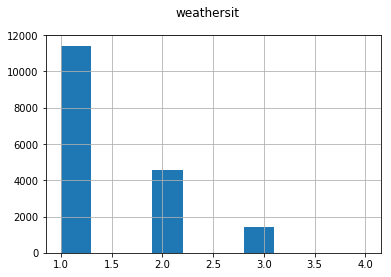

In [113]:
bikes_hour_df['weathersit'].hist().plot()
plt.suptitle('weathersit')
plt.show()

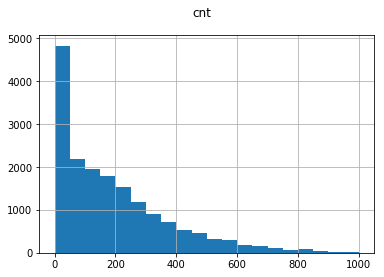

In [114]:
bikes_hour_df['cnt'].hist(bins=20, range=(0,1000)).plot()
plt.suptitle('cnt')
plt.show()

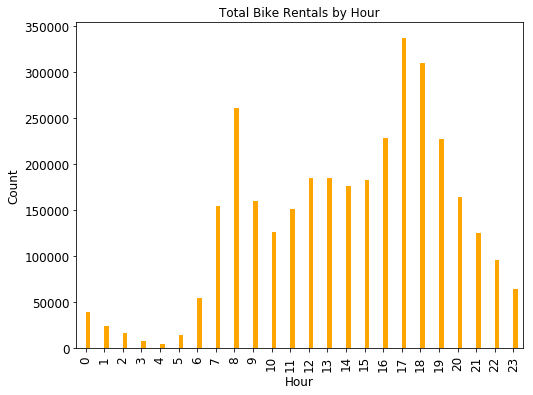

In [115]:
# alternative way of plotting using groupby
ax = bikes_hour_df[['hr','cnt']].groupby(['hr']).sum().reset_index().plot(kind='bar', figsize=(8, 6),
                                       legend = False, title ="Total Bike Rentals by Hour", 
                                       color='orange', fontsize=12)
ax.set_xlabel("Hour", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

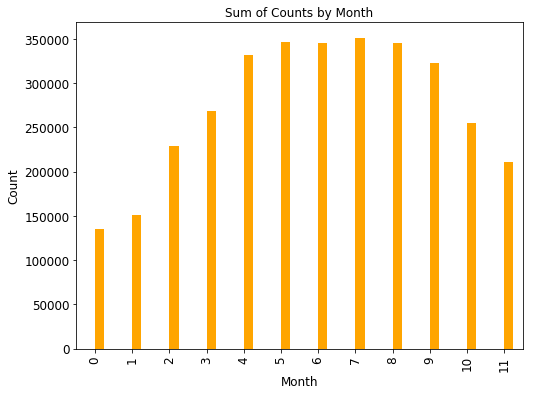

In [116]:
ax = bikes_hour_df[['mnth','cnt']].groupby(['mnth']).sum().reset_index().plot(kind='bar', figsize=(8, 6),
                                       legend = False, title ="Sum of Counts by Month", 
                                       color='orange', fontsize=12)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

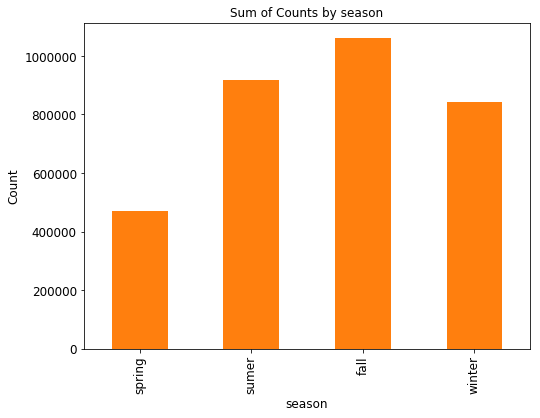

In [117]:
ax = bikes_hour_df[['season','cnt']].groupby(['season']).sum().reset_index().plot(kind='bar', figsize=(8, 6),
                                       legend = False, title ="Sum of Counts by season", 
                                         stacked=True, fontsize=12)
ax.set_xlabel("season", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_xticklabels(['spring','sumer','fall','winter'])
plt.show()

<H2>Modeling with Linear Regression</H2>

**Simple model with all numerical variables**

In [118]:
# simple approach - make a copy for editing without affecting original
bike_df_model_ready = bikes_hour_df.copy()

outcome = 'cnt'
# create a feature list for each modeling - experiment by adding features to the exclusion list
features = [feat for feat in list(bike_df_model_ready) if feat not in [outcome, 'instant', 'dteday']]  

# split data into train and test portions and model
X_train, X_test, y_train, y_test = train_test_split(bike_df_model_ready[features], 
                                                 bike_df_model_ready[['cnt']], 
                                                 test_size=0.3, random_state=42)
from sklearn import linear_model
model_lr = linear_model.LinearRegression()
 
# train the model on training set
model_lr.fit(X_train, y_train)

# make predictions using the testing set
predictions = model_lr.predict(X_test)

# root mean squared error
print("Root Mean squared error: %.2f" % sqrt(mean_squared_error(y_test, predictions)))
 

Root Mean squared error: 143.08


In [119]:

bike_df_model_ready.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
13085,13086,2012-07-04,3,1,7,10,1,3,0,1,0.80,0.7273,0.46,0.0,447
11451,11452,2012-04-27,2,1,4,8,0,5,1,1,0.40,0.4091,0.50,0.0,592
7162,7163,2011-10-31,4,0,10,1,0,1,1,1,0.26,0.3030,0.81,0.0,13
14242,14243,2012-08-21,3,1,8,15,0,2,1,1,0.76,0.6667,0.37,0.0,302
14495,14496,2012-09-01,3,1,9,4,0,6,0,1,0.70,0.6515,0.70,0.0,12


**Model using Polynomials - 2 & 3 degrees**

In [121]:
# make a copy for editing without affecting original
bike_df_model_ready = bikes_hour_df.copy()

outcome = 'cnt'
# create a feature list for eash modeling - experiment by adding features to the exclusion list
features = [feat for feat in list(bike_df_model_ready) if feat not in [outcome, 'instant', 'dteday']]  

# split data into train and test portions and model
X_train, X_test, y_train, y_test = train_test_split(bike_df_model_ready[features], 
                                                 bike_df_model_ready[['cnt']], 
                                                 test_size=0.3, random_state=42)

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

from sklearn import linear_model
model_lr = linear_model.LinearRegression()
 
# train the model on training set
model_lr.fit(X_train, y_train)

# make predictions using the testing set
predictions = model_lr.predict(X_test)
 
# root mean squared error
print("Root Mean squared error with PolynomialFeatures set to 2 degrees: %.2f" 
      % sqrt(mean_squared_error(y_test, predictions)))



Root Mean squared error with PolynomialFeatures set to 2 degrees: 122.96


In [123]:
# make a copy for editing without affecting original
bike_df_model_ready = bikes_hour_df.copy()

outcome = 'cnt'
# create a feature list for eash modeling - experiment by adding features to the exclusion list
features = [feat for feat in list(bike_df_model_ready) if feat not in [outcome, 'instant', 'dteday']]  

# split data into train and test portions and model
X_train, X_test, y_train, y_test = train_test_split(bike_df_model_ready[features], 
                                                 bike_df_model_ready[['cnt']], 
                                                 test_size=0.3, random_state=42)

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(3)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)
 
from sklearn import linear_model
model_lr = linear_model.LinearRegression()
 
# train the model on training set
model_lr.fit(X_train, y_train)

# make predictions using the testing set
predictions = model_lr.predict(X_test)
 
# root mean squared error
print("Root Mean squared error with PolynomialFeatures set to 3 degrees: %.2f" 
      % sqrt(mean_squared_error(y_test, predictions)))

Root Mean squared error with PolynomialFeatures set to 3 degrees: 111.65


**Model with simple feature engineering**

In [146]:
def prepare_data_for_model(raw_dataframe, target_columns, drop_first = False, make_na_col = True):
    # dummy all categorical fields 
    dataframe_dummy = pd.get_dummies(raw_dataframe, columns=target_columns, 
                                     drop_first=drop_first, 
                                     dummy_na=make_na_col)
    return (dataframe_dummy)

# make a copy for editing without affecting original
bike_df_model_ready = bikes_hour_df.copy()
bike_df_model_ready = bike_df_model_ready.sort_values('instant')

# dummify categorical columns
bike_df_model_ready = prepare_data_for_model(bike_df_model_ready, 
                                             target_columns = ['season', 'weekday', 'weathersit'])

# remove the nan colums in dataframe as most are outcome variable and we can't use them
bike_df_model_ready = bike_df_model_ready.dropna() 


outcome = 'cnt'
features = [feat for feat in list(bike_df_model_ready) if feat not in [outcome, 'instant',  'dteday']]  

 
X_train, X_test, y_train, y_test = train_test_split(bike_df_model_ready[features], 
                                                 bike_df_model_ready[['cnt']], 
                                                 test_size=0.5, 
                                                 random_state=42)
from sklearn import linear_model
model_lr = linear_model.LinearRegression()
 
# train the model on training set
model_lr.fit(X_train, y_train)

# make predictions using the testing set
predictions = model_lr.predict(X_test)
 
# print coefficients as this is what our web application will use in the end
print('Coefficients: \n', model_lr.coef_)

# root mean squared error
print("Root Mean squared error: %.2f" % sqrt(mean_squared_error(y_test, predictions)))
 

Coefficients: 
 [[  8.15248087e+01  -3.05053709e-01   7.31700288e+00  -2.19679661e+01
    1.17580123e+01   2.56576596e+02   1.06754237e+02  -2.00225607e+02
    3.93454538e+01  -2.48308234e+01   5.77775971e-01  -2.25833573e+01
    4.68364047e+01  -7.10542736e-14  -1.04545740e+00  -4.78960599e+00
    3.23404241e-01  -2.68680374e+00  -4.23627017e+00   1.17932190e+00
    1.12554112e+01   0.00000000e+00  -3.98537853e+00   5.34887131e+00
   -2.80811611e+01   2.67176683e+01   0.00000000e+00]]
Root Mean squared error: 139.40


In [195]:
# simple approach - make a copy for editing without affecting original
bike_df_model_ready = bikes_hour_df.copy()
bike_df_model_ready = bike_df_model_ready.sort_values('instant')

# dummify categorical columns
bike_df_model_ready = prepare_data_for_model(bike_df_model_ready, 
                                             target_columns = ['season', 'weekday', 'weathersit'])
list(bike_df_model_ready.head(1).values)

# remove the nan colums in dataframe as most are outcome variable and we can't use them
bike_df_model_ready = bike_df_model_ready.dropna() 


outcome = 'cnt'
features = [feat for feat in list(bike_df_model_ready) if feat not in [outcome, 'instant', 'dteday']]  

 
X_train, X_test, y_train, y_test = train_test_split(bike_df_model_ready[features], 
                                                 bike_df_model_ready[['cnt']], 
                                                 test_size=0.5, 
                                                 random_state=42)
 
from sklearn.ensemble import GradientBoostingRegressor
model_gbr = GradientBoostingRegressor()
model_gbr.fit(X_train, np.ravel(y_train))
predictions = model_gbr.predict(X_test)

# root mean squared error
print("Root Mean squared error: %.2f" % sqrt(mean_squared_error(y_test, predictions)))
 

Root Mean squared error: 68.12


**Modeling Time**

Here're going to apply one last engineering trick, we're going to keep track of the previous hour's count and use that as a feature for the model.


In [203]:

# prior hours
bikes_hour_df_shift = bikes_hour_df[['dteday','hr','cnt']].groupby(['dteday','hr']).sum().reset_index()
bikes_hour_df_shift.sort_values(['dteday','hr'])
# shift the count of the last two hours forward so the new count can take in consideratio how the last two hours went 
bikes_hour_df_shift['sum_hr_shift_1'] = bikes_hour_df_shift.cnt.shift(+1)
bikes_hour_df_shift['sum_hr_shift_2'] = bikes_hour_df_shift.cnt.shift(+2)

bike_df_model_ready =  pd.merge(bikes_hour_df, bikes_hour_df_shift[['dteday', 'hr', 'sum_hr_shift_1', 'sum_hr_shift_2']], how='inner', on = ['dteday', 'hr'])

# drop NAs caused by our shifting fields around
bike_df_model_ready = bike_df_model_ready.dropna()

outcome = 'cnt'
# create a feature list for each modeling - experiment by adding features to the exclusion list
features = [feat for feat in list(bike_df_model_ready) if feat not in [outcome, 'instant', 'dteday','casual', 'registered']]  

# split data into train and test portions and model
X_train, X_test, y_train, y_test = train_test_split(bike_df_model_ready[features], 
                                                 bike_df_model_ready[['cnt']], 
                                                 test_size=0.3, random_state=42)

from sklearn.ensemble import GradientBoostingRegressor
model_gbr = GradientBoostingRegressor()
model_gbr.fit(X_train, np.ravel(y_train))
predictions = model_gbr.predict(X_test)

# root mean squared error
print("Root Mean squared error: %.2f" % sqrt(mean_squared_error(y_test, predictions)))

Root Mean squared error: 44.43


<H3>Parsimonious Model for our web application</H3>
<BR>
We are going to keep things simple for the sake of our web application and only use four features: <B>season, hr, holiday, temp</B>. 

Let's calculate the R^2 score of each feature to see how each helps us model bike demand (remember that an R^2 of 1 is perfect and an negative R^2 is bad):
    

In [198]:
# prior hours
np.mean(bikes_hour_df_shift['sum_hr_shift_1'])

189.47117044539073

In [162]:
 

# loop through each feature and calculate the R^2 score
features = ['hr', 'season', 'holiday', 'temp', 'cnt_hr_shift_1', 'cnt_hr_shift_2']
from sklearn import linear_model
from sklearn.metrics import r2_score

# split data into train and test portions and model
X_train, X_test, y_train, y_test = train_test_split(bike_df_model_ready[features], 
                                                 bike_df_model_ready[['cnt']], 
                                                 test_size=0.3, random_state=42)
    
for feat in features:
    model_lr = linear_model.LinearRegression()
    model_lr.fit(X_train[[feat]], y_train)
    predictions = model_lr.predict(X_test[[feat]])
    print('R^2 for %s is %f' % (feat, r2_score(y_test, predictions)))
    

R^2 for hr is 0.160161
R^2 for season is 0.034888
R^2 for holiday is -0.001098
R^2 for temp is 0.154656
R^2 for cnt_hr_shift_1 is 0.717562
R^2 for cnt_hr_shift_2 is 0.368819


In [163]:
# simple approach - make a copy for editing without affecting original
bike_df_model_ready = bikes_hour_df[['hr', 'season', 'holiday', 'temp', 'cnt']].copy()

outcome = 'cnt'

# dummify categorical columns
bike_df_model_ready = prepare_data_for_model(bike_df_model_ready,  drop_first = False, 
                                             make_na_col = False, target_columns = ['season'])

features = [feat for feat in bike_df_model_ready if feat not in ['cnt']]  

# split data into train and test portions and model
X_train, X_test, y_train, y_test = train_test_split(bike_df_model_ready[features], 
                                                 bike_df_model_ready[['cnt']], 
                                                 test_size=0.3, random_state=42)
from sklearn import linear_model
model_lr = linear_model.LinearRegression()

for feat in features:
    model_lr = linear_model.LinearRegression()
    # train the model on training set
    model_lr.fit(X_train[[feat]], y_train)
    predictions = model_lr.predict(X_test[[feat]])
    
    print('R^2 for %s is %f' % (feat, r2_score(y_test, predictions)))
    


R^2 for hr is 0.160161
R^2 for holiday is -0.001098
R^2 for temp is 0.154656
R^2 for cnt_hr_shift_1 is 0.717562
R^2 for cnt_hr_shift_2 is 0.368819
R^2 for season_1 is 0.064166
R^2 for season_2 is 0.003960
R^2 for season_3 is 0.020916
R^2 for season_4 is 0.001343


Let's look at the coefficients from our model and what they mean:

In [168]:
# train the model on training set
model_lr.fit(X_train, y_train)

# make predictions using the testing set
predictions = model_lr.predict(X_test)
 
# root mean squared error
print("Root Mean squared error: %.2f" % sqrt(mean_squared_error(y_test, predictions)))
print('\n')
print('Intercept: %f' % model_lr.intercept_)

# features with coefficients 
feature_coefficients  = pd.DataFrame({'coefficients':model_lr.coef_[0], 
                                    'features':X_train.columns.values})

feature_coefficients.sort_values('coefficients')

Root Mean squared error: 85.17


Intercept: -29.568744


,coefficients,features
6,-14.839810,season_3
3,-0.466608,cnt_hr_shift_2
5,0.190634,season_2
2,1.156538,cnt_hr_shift_1
0,1.742991,hr
4,2.543190,season_1
7,12.105986,season_4
1,139.444579,temp


In [182]:
# set up constants for our coefficients 
INTERCEPT = -121.029547
COEF_HOLIDAY = -23.426176   # day is holiday or not
COEF_HOUR = 8.631624        # hour (0 to 23)
COEF_SEASON_1 = 3.861149    # 1:springer
COEF_SEASON_2 = -1.624812   # 2:summer
COEF_SEASON_3 = -41.245562  # 3:fall
COEF_SEASON_4 = 39.009224   # 4:winter
COEF_TEMP = 426.900259      # norm temp in Celsius -8 to +39

<H3>Predicting with coefficients - a lightweight way of getting estimates</H3>

Now we can use the above coefficients and the regression equation:
<B>y^ = b0 + bx1 + bxn</b>

It is important to remember that an x unit change in one feature works to estimate y when all other values are held constant. This means we need to get the mean value of all our features to plug into our regresssion equation.


In [189]:
np.mean(X_train['temp'])

0.49751870426703937

In [191]:
# mean values
MEAN_HOLIDAY = 0.0275   # day is holiday or not
MEAN_HOUR = 11.6        # hour (0 to 23)
MEAN_SEASON_1 = 1       # 1:spring
MEAN_SEASON_2 = 0       # 2:summer
MEAN_SEASON_3 = 0       # 3:fall
MEAN_SEASON_4 = 0       # 4:winter
MEAN_TEMP = 0.4967      # norm temp in Celsius -8 to +39


# try predicting something - 9AM with all other features held constant
rental_counts = INTERCEPT + (MEAN_HOLIDAY * COEF_HOLIDAY) \
    + (9 * COEF_HOUR) \
    + (MEAN_SEASON_1 * COEF_SEASON_1)  + (MEAN_SEASON_2 * COEF_SEASON_2) \
    + (MEAN_SEASON_3 * COEF_SEASON_3)  + (MEAN_SEASON_4 * COEF_SEASON_4) \
    + (MEAN_TEMP * COEF_TEMP)

print('Estimated bike rental count for selected parameters: %i' % int(rental_counts))    

Estimated bike rental count for selected parameters: 158
